In [266]:
import glob
import json
import spacy
import pandas as pd
import random
#from langdetect import detect    #not detecting language correctly
from rouge import Rouge
from summa import summarizer
from sklearn.model_selection import train_test_split
from spacy_langdetect import LanguageDetector
import matplotlib.pyplot as plt
import numpy as np

In [197]:
path = '/home/prajakta/Documents/SharpestMinds/COVID-analysis/data/*.json'
files = glob.glob(path)
papers = []
for file in files:
    with open(file) as json_file:
            text = json.load(json_file)
            papers.append([text['paper_id'], text['bodytext'], text['abstract']])
data = pd.DataFrame(papers, columns = ['paper_id', 'bodytext', 'abstract'])
filter = data.abstract != ""
data = data[filter]
#data = data[(data.paper_id != "a6f478369adbfd8be967251a9bb0dd17fa436c45")]
x = data.drop('abstract', axis = 1)
y = data.abstract


In [220]:
data.shape

(8755, 18)

Language not detected correctly using Spacy LanguageDetector.

In [182]:
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
language = []
score = []
for i in range(len(data.index)):
    if data.iloc[i].paper_id == "a6f478369adbfd8be967251a9bb0dd17fa436c45":
        print(i)
        nlp_abstract = str(data.iloc[i].abstract)
        language.append(nlp(nlp_abstract)._.language['language'])
        score.append(nlp(nlp_abstract)._.language['score'])
        print(nlp(str(data.iloc[57].abstract))._.language['language'])

#language, score
#data["language"] = pd.Series(language)
#data['language'] = data.nlp_abstract.map(lambda x: x._.language['language'])

57
en


In [185]:
text = str(data[data.paper_id == "a6f478369adbfd8be967251a9bb0dd17fa436c45"].abstract)
doc = nlp(text)
print(doc._.language)

{'language': 'vi', 'score': 0.7142816108221657}


In [191]:
pd.notnull(data).sum(axis = 0)

paper_id    8755
bodytext    8755
abstract    8755
dtype: int64

In [195]:
(data.abstract == "").value_counts()

False    8755
Name: abstract, dtype: int64

In [196]:
(data.bodytext == "").value_counts()

False    8755
Name: bodytext, dtype: int64

In [193]:
X_train, Y_train, X_test, Y_test = train_test_split(x, y, test_size = 0.2, random_state= 10)

In [14]:
X_test.describe()

count                                                   159
unique                                                  159
top        Background: Human coronaviruses (HCoVs) are a...
freq                                                      1
Name: abstract, dtype: object

In [15]:
Y_test.describe()

count                                                    40
unique                                                   40
top        Background: Non-pharmaceutical strategies are...
freq                                                      1
Name: abstract, dtype: object

In [16]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(data.bodytext[5])
abstract = data.abstract[5]
sentences = list(doc.sents)
sentence = random.choice(sentences)  
type(str(sentence))

str

In [17]:
evaluator = Rouge()
scores = evaluator.get_scores(str(sentence), abstract)
scores

[{'rouge-1': {'f': 0.0909090891507843,
   'p': 0.4666666666666667,
   'r': 0.050359712230215826},
  'rouge-2': {'f': 0.00653594599662568,
   'p': 0.034482758620689655,
   'r': 0.0036101083032490976},
  'rouge-l': {'f': 0.1304347799533318,
   'p': 0.41379310344827586,
   'r': 0.07741935483870968}}]

In [198]:
data["length_abstract"] = data.abstract.apply(lambda x: str(x).count(" "))
data["length_bodytext"] = data.bodytext.apply(lambda x: str(x).count(" "))

In [201]:
#%%timeit
data["textrank_summary_abstractlength"]=data.apply(lambda x: summarizer.summarize(str(x.bodytext), words = x.length_abstract), axis = 1)
data.head()

,paper_id,bodytext,abstract,length_abstract,length_bodytext,textrank_summary_abstractlength
0,17413f651645c2b9c92555e9ce1404b9290eccab,a1111111111 a1111111111 a1111111111 a11111111...,"The cellular serine protease TMPRSS2, a membe...",266,3543,"Moreover, we demonstrate that spread of FLUAV ..."
3,ab8c1e32b66b02cd703799df3d2ee37a1cb369b7,Middle East respiratory syndrome coronavirus ...,The persistent public health threat of infect...,223,4249,The current study determined the effects of a ...
4,685efeb0ad4c214b8295dc4f723c3269464772d8,Bats have been increasingly associated with e...,We report on the isolation of a novel fusogen...,154,4514,Maximum Likelihood trees were prepared using a...
5,09ccb3b9fece55e72c3acb85c4259de62a9c9e0c,Bovine respiratory disease (BRD) incorporates...,Background: The aim of this study was to dete...,274,4392,The objective of this study was to ascertain t...
7,93d080273b1f33330243dd140a35ba890ddd2973,Nurses leaving their jobs or leaving the prof...,Background: Nurses leaving their jobs and the...,297,7159,Exclusion criteria were as follows: Reports fr...


In [212]:
def cal_rougescore(row,metric, measure):
    if row.textrank_summary_abstractlength == "":
        return 0
    else:
        return evaluator.get_scores(str(row.textrank_summary_abstractlength), str(row.abstract))[0][metric][measure]

In [216]:
evaluator = Rouge()
#,data["rouge_2"],data["rouge-l"]  
data["rouge_1_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'f'), axis = 1)
data["rouge_2_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'f'), axis = 1)
data["rouge_l_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'f'), axis = 1)

In [217]:
evaluator = Rouge()
#,data["rouge_2"],data["rouge-l"]  
data["rouge_1_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'p'), axis = 1)
data["rouge_2_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'p'), axis = 1)
data["rouge_l_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'p'), axis = 1)

In [218]:
evaluator = Rouge()
#,data["rouge_2"],data["rouge-l"]  
data["rouge_1_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'r'), axis = 1)
data["rouge_2_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'r'), axis = 1)
data["rouge_l_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'r'), axis = 1)

Text(0.5, 0, 'abstract length')

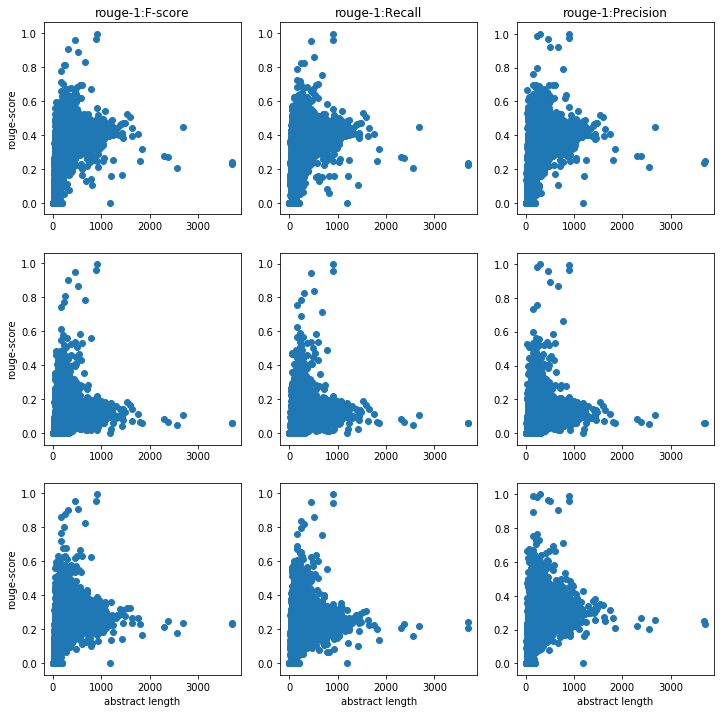

In [276]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(data.length_abstract, data.rouge_1_f)
#plt.line(data.length_abstract, np.mean(data.rouge_1_f), linestyle = '--')
plt.title('rouge-1:F-score')
plt.ylabel('rouge-score')

#plt.xlabel('abstract length')

plt.subplot(3, 3, 2)
plt.scatter(data.length_abstract, data.rouge_1_r)
plt.title('rouge-1:Recall')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 3)
plt.scatter(data.length_abstract, data.rouge_1_p)
plt.title('rouge-1:Precision')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 4)
plt.scatter(data.length_abstract, data.rouge_2_f)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 5)
plt.scatter(data.length_abstract, data.rouge_2_r)
#plt.title('rouge-2:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 6)
plt.scatter(data.length_abstract, data.rouge_2_p)
#plt.title('rouge-3:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 7)
plt.scatter(data.length_abstract, data.rouge_l_f)
#plt.title('rouge-l:F-score')
plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 8)
plt.scatter(data.length_abstract, data.rouge_l_r)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 9)
plt.scatter(data.length_abstract, data.rouge_l_p)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')


In [313]:
clean_data = data[data.length_abstract > 50]
clean_data.shape

(8500, 18)

Text(0.5, 0, 'abstract length')

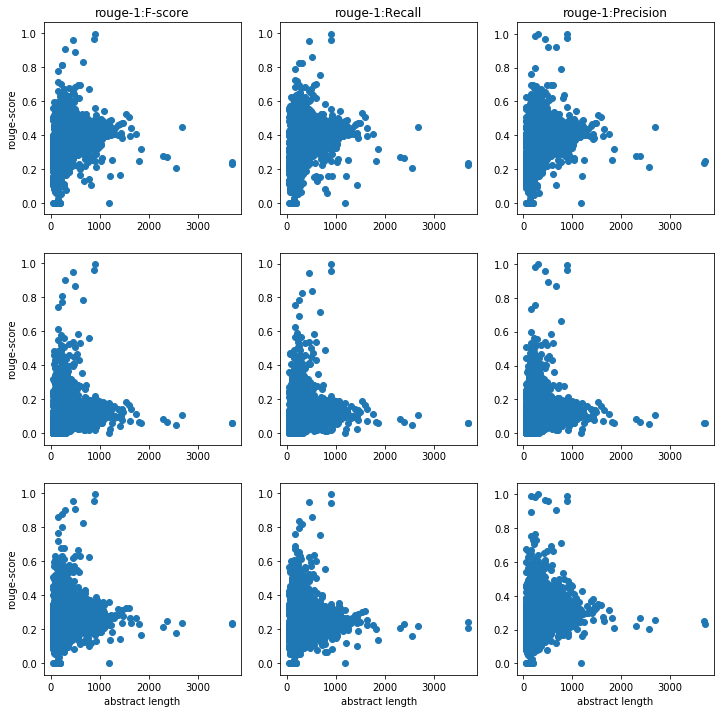

In [314]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(clean_data.length_abstract, clean_data.rouge_1_f)
#plt.line(clean_data.length_abstract, np.mean(clean_data.rouge_1_f), linestyle = '--')
plt.title('rouge-1:F-score')
plt.ylabel('rouge-score')

#plt.xlabel('abstract length')

plt.subplot(3, 3, 2)
plt.scatter(clean_data.length_abstract, clean_data.rouge_1_r)
plt.title('rouge-1:Recall')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 3)
plt.scatter(clean_data.length_abstract, clean_data.rouge_1_p)
plt.title('rouge-1:Precision')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 4)
plt.scatter(clean_data.length_abstract, clean_data.rouge_2_f)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 5)
plt.scatter(clean_data.length_abstract, clean_data.rouge_2_r)
#plt.title('rouge-2:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 6)
plt.scatter(clean_data.length_abstract, clean_data.rouge_2_p)
#plt.title('rouge-3:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 7)
plt.scatter(clean_data.length_abstract, clean_data.rouge_l_f)
#plt.title('rouge-l:F-score')
plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 8)
plt.scatter(clean_data.length_abstract, clean_data.rouge_l_r)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 9)
plt.scatter(clean_data.length_abstract, clean_data.rouge_l_p)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

In [306]:
data.length_abstract.describe()

count    8755.000000
mean      258.492290
std       177.496159
min         1.000000
25%       175.000000
50%       229.000000
75%       295.000000
max      3705.000000
Name: length_abstract, dtype: float64

In [312]:
data.length_abstract.quantile(0.01)

22.0

In [319]:
data.rouge_1_f.describe()

count    8755.000000
mean        0.371355
std         0.100203
min         0.000000
25%         0.318132
50%         0.380952
75%         0.434603
max         0.997227
Name: rouge_1_f, dtype: float64